# A/B Testing on Mobile Games Cookie Cats

### Load the data, remove duplicate rows, and check the overall structure.

#### data from https://www.kaggle.com/datasets/mursideyarkin/mobile-games-ab-testing-cookie-cats

In [1]:
# Current R version
R.Version()$version.string

[1] "R version 4.3.2 (2023-10-31 ucrt)"

In [2]:
# load libraries

if (!require(tidyverse)) install.packages('tidyverse', dependencies=TRUE)   # data manipulation
suppressWarnings(suppressMessages(library(tidyverse) ))

if (!require(ggplot2)) install.packages('ggplot2', dependencies=TRUE) #  data visualization
suppressWarnings(suppressMessages(library(ggplot2)))

if (!require(caret)) install.packages('caret', dependencies=TRUE) 
suppressWarnings(suppressMessages(library(caret)))

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: caret

Loading required package: lattice


Attaching package: 'caret'


The following object is masked from 'package:purrr':

    lift




In [3]:
ab_df <- read.csv("cookie_cats.csv")

ab_df <- unique(ab_df)

str(ab_df)

'data.frame':	90189 obs. of  5 variables:
 $ userid        : int  116 337 377 483 488 540 1066 1444 1574 1587 ...
 $ version       : chr  "gate_30" "gate_30" "gate_40" "gate_40" ...
 $ sum_gamerounds: int  3 38 165 1 179 187 0 2 108 153 ...
 $ retention_1   : logi  FALSE TRUE TRUE FALSE TRUE TRUE ...
 $ retention_7   : logi  FALSE FALSE FALSE FALSE TRUE TRUE ...


    userid: Unique ID of the game player
    
    version: Whether the game player is in gate_30 (control group) or gate_40
    
    sum_gamerounds: The number of times a game player has played the game in the two weeks since installing it.
    
    retention_1: Whether the game player logged back in one day after installing the game.
    
    retention_7: Whether the game player logged back in a week after installing the game.

In [4]:
ab_df %>% summary()

     userid          version          sum_gamerounds     retention_1    
 Min.   :    116   Length:90189       Min.   :    0.00   Mode :logical  
 1st Qu.:2512230   Class :character   1st Qu.:    5.00   FALSE:50036    
 Median :4995815   Mode  :character   Median :   16.00   TRUE :40153    
 Mean   :4998412                      Mean   :   51.87                  
 3rd Qu.:7496452                      3rd Qu.:   51.00                  
 Max.   :9999861                      Max.   :49854.00                  
 retention_7    
 Mode :logical  
 FALSE:73408    
 TRUE :16781    
                
                
                

### Transform the data variables to each type and perform a simple EDA.

In [5]:
ab_df$version <- factor(ab_df$version)

ab_df$retention_1 <- factor(ab_df$retention_1)

ab_df$retention_7 <- factor(ab_df$retention_7)

In [6]:
str(ab_df)

'data.frame':	90189 obs. of  5 variables:
 $ userid        : int  116 337 377 483 488 540 1066 1444 1574 1587 ...
 $ version       : Factor w/ 2 levels "gate_30","gate_40": 1 1 2 2 2 2 1 2 2 2 ...
 $ sum_gamerounds: int  3 38 165 1 179 187 0 2 108 153 ...
 $ retention_1   : Factor w/ 2 levels "FALSE","TRUE": 1 2 2 1 2 2 1 1 2 2 ...
 $ retention_7   : Factor w/ 2 levels "FALSE","TRUE": 1 1 1 1 2 2 1 1 2 1 ...


In [7]:
ab_df %>% 
    as_tibble() %>%
    head() # See top 6 rows 

userid,version,sum_gamerounds,retention_1,retention_7
<int>,<fct>,<int>,<fct>,<fct>
116,gate_30,3,FALSE,FALSE
337,gate_30,38,TRUE,FALSE
377,gate_40,165,TRUE,FALSE
483,gate_40,1,FALSE,FALSE
488,gate_40,179,TRUE,TRUE
540,gate_40,187,TRUE,TRUE


In [8]:
# Check for any NA values in the entire dataset
na_summary <- sapply(ab_df, function(x) sum(is.na(x)))

# Display columns with NA values and their counts
na_summary

userid        version sum_gamerounds    retention_1    retention_7 
             0              0              0              0              0

In [9]:
if (!require(repr)) install.packages('repr', dependencies=TRUE) 
suppressWarnings(suppressMessages(library(repr)))

Loading required package: repr



In [10]:
options(repr.plot.width=12, repr.plot.height=8)

My_Theme = theme(
  axis.title.x = element_text(size = 16),
  axis.text.x = element_text(size = 14),
  axis.title.y = element_text(size = 16),
  axis.text.y = element_text(size = 14),
  legend.title=element_text(size=16),
  legend.text=element_text(size=14))

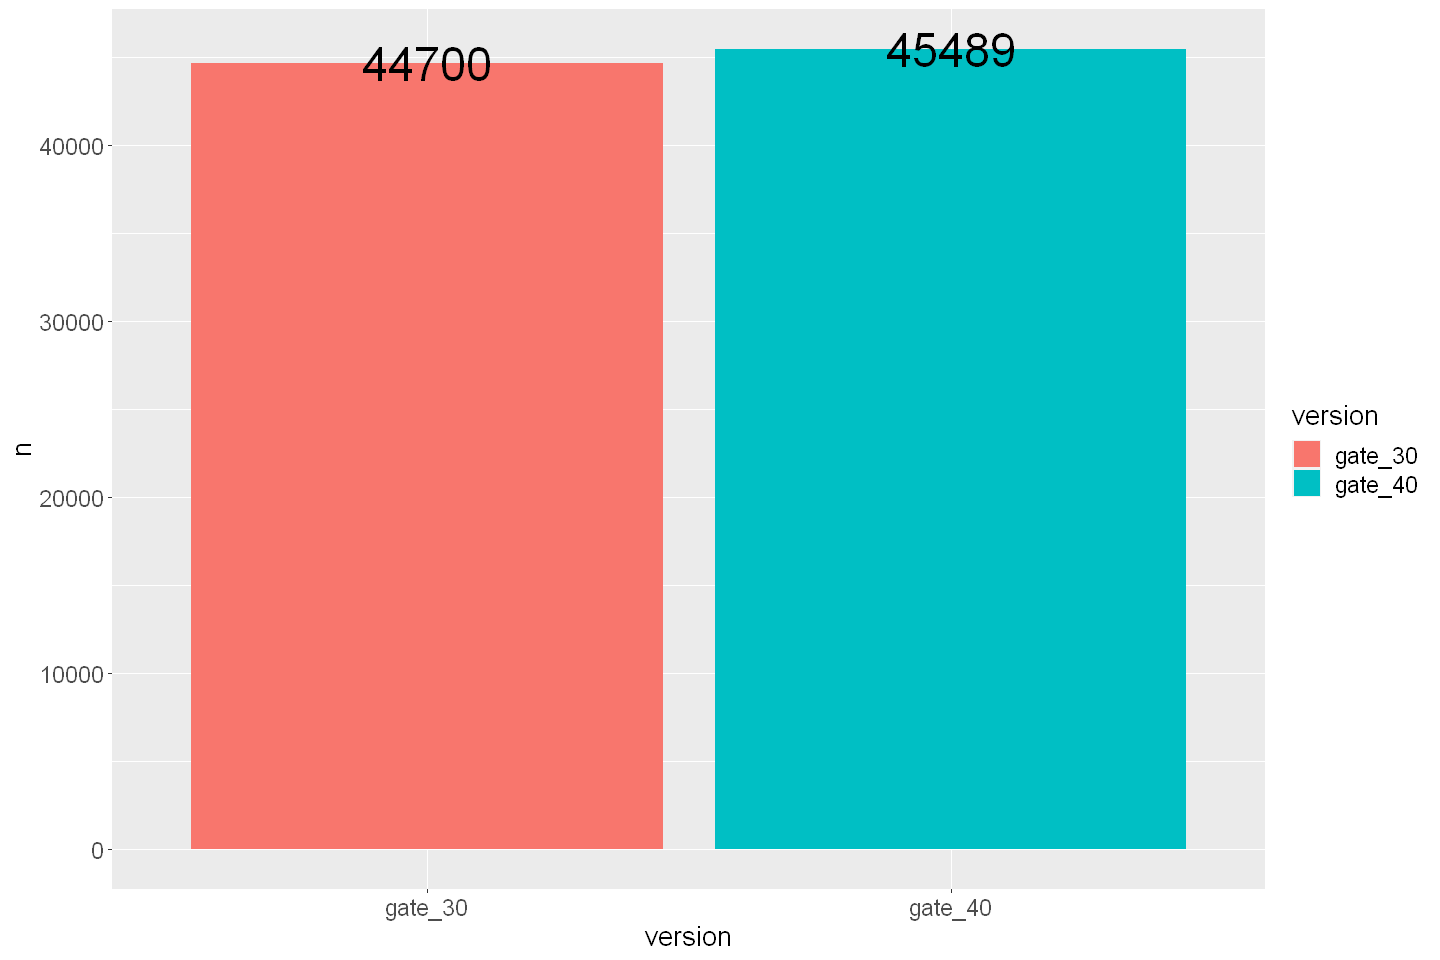

In [11]:
ab_df %>% 
    group_by(version) %>% 
    count() %>% 
    ggplot(aes(x=version, y=n, fill = version)) + geom_bar(stat = "identity") + geom_text(aes(label = n), size = 10) + My_Theme

#### gate_40 group is slightly more than the number of game players belonging to the gate_30 group.

Warning message:
"Removed 3994 rows containing non-finite values (`stat_boxplot()`)."
Warning message:
"Removed 3994 rows containing non-finite values (`stat_boxplot()`)."


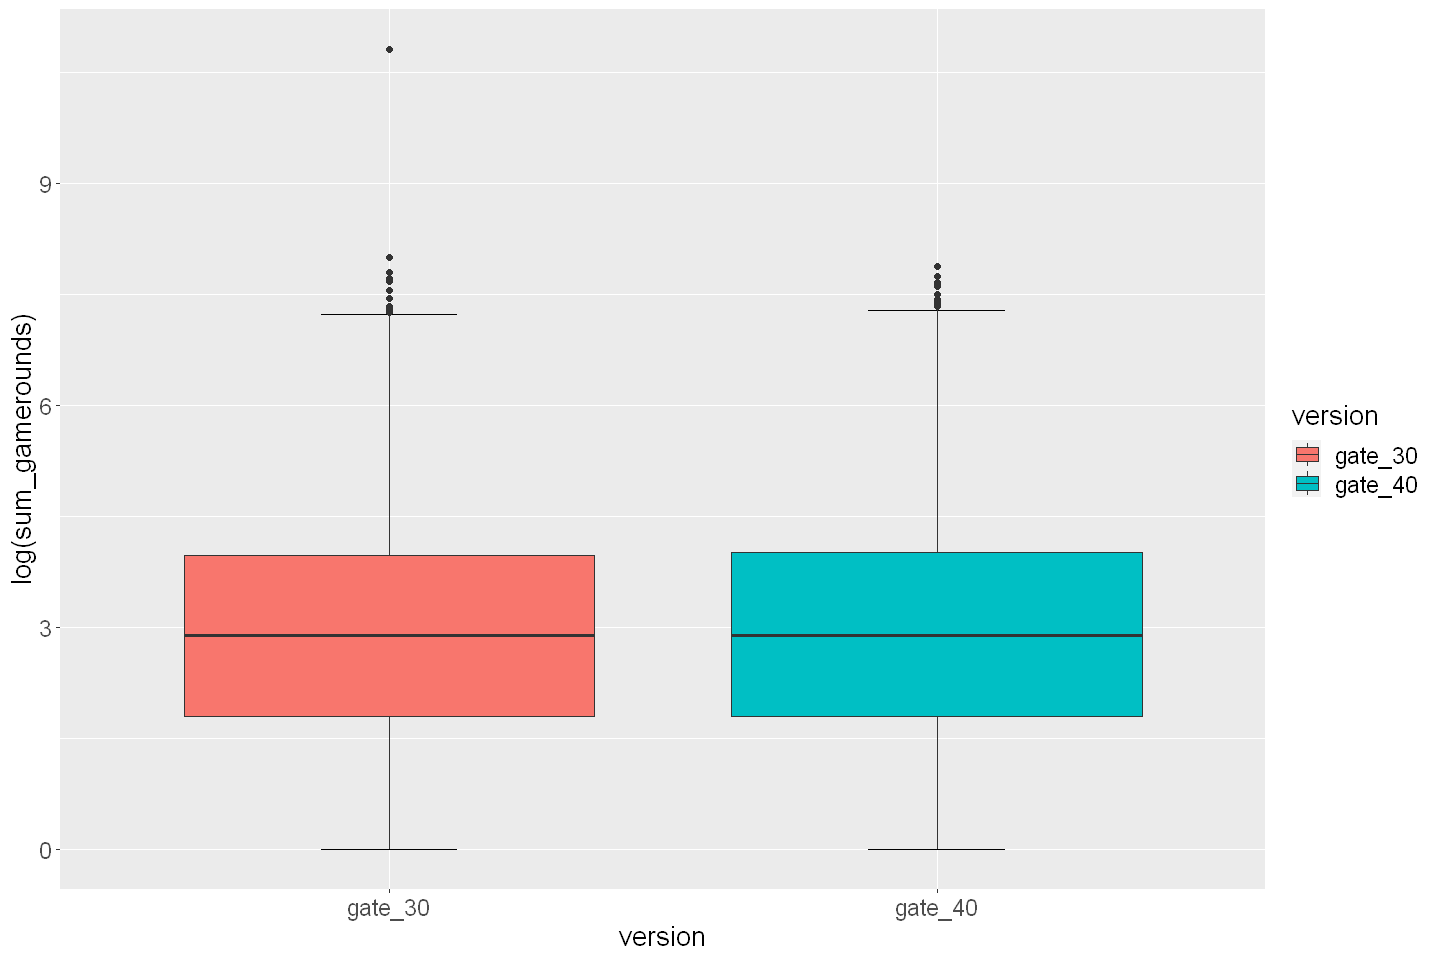

In [50]:
ab_df %>% ggplot( aes(x = version, y = log(sum_gamerounds), fill = version)) + 
  stat_boxplot(geom = "errorbar",
               width = 0.25) + 
  geom_boxplot() + My_Theme

In [13]:
# Filter the data frame where sum_gamerounds is 0 and count the number of userid
userid_count <- ab_df %>%
  filter(sum_gamerounds == 0) %>%
  summarise(count = n())

# Display the count
userid_count$count

[1] 3994

#### There are 3994 players never played the game, just installed it. Is it too much?

#### one extreme outlier at sum_gamerounds = 49854

In [14]:
# Remove rows where sum_gamerounds is 0 or 49854
df_filtered <- ab_df %>%
  filter(!(sum_gamerounds %in% c(0, 49854)))

In [15]:
df_filtered %>% summary()

     userid           version      sum_gamerounds   retention_1   retention_7  
 Min.   :    116   gate_30:42762   Min.   :   1.0   FALSE:46128   FALSE:69443  
 1st Qu.:2513062   gate_40:43432   1st Qu.:   6.0   TRUE :40066   TRUE :16751  
 Median :4995739                   Median :  18.0                              
 Mean   :4997568                   Mean   :  53.7                              
 3rd Qu.:7495053                   3rd Qu.:  54.0                              
 Max.   :9999861                   Max.   :2961.0                              

In [16]:
df_retention_ab <- df_filtered %>%
  group_by(version) %>%
  summarise(
    user_count = n(),
    retention_1 = mean(as.numeric(as.logical(retention_1)), na.rm = TRUE),
    retention_7 = mean(as.numeric(as.logical(retention_7)), na.rm = TRUE),
    sum_gamerounds = sum(sum_gamerounds, na.rm = TRUE)
  )

In [17]:
df_retention_ab

version,user_count,retention_1,retention_7,sum_gamerounds
<fct>,<int>,<dbl>,<dbl>,<int>
gate_30,42762,0.4675413,0.1984238,2294941
gate_40,43432,0.4621707,0.1903205,2333530


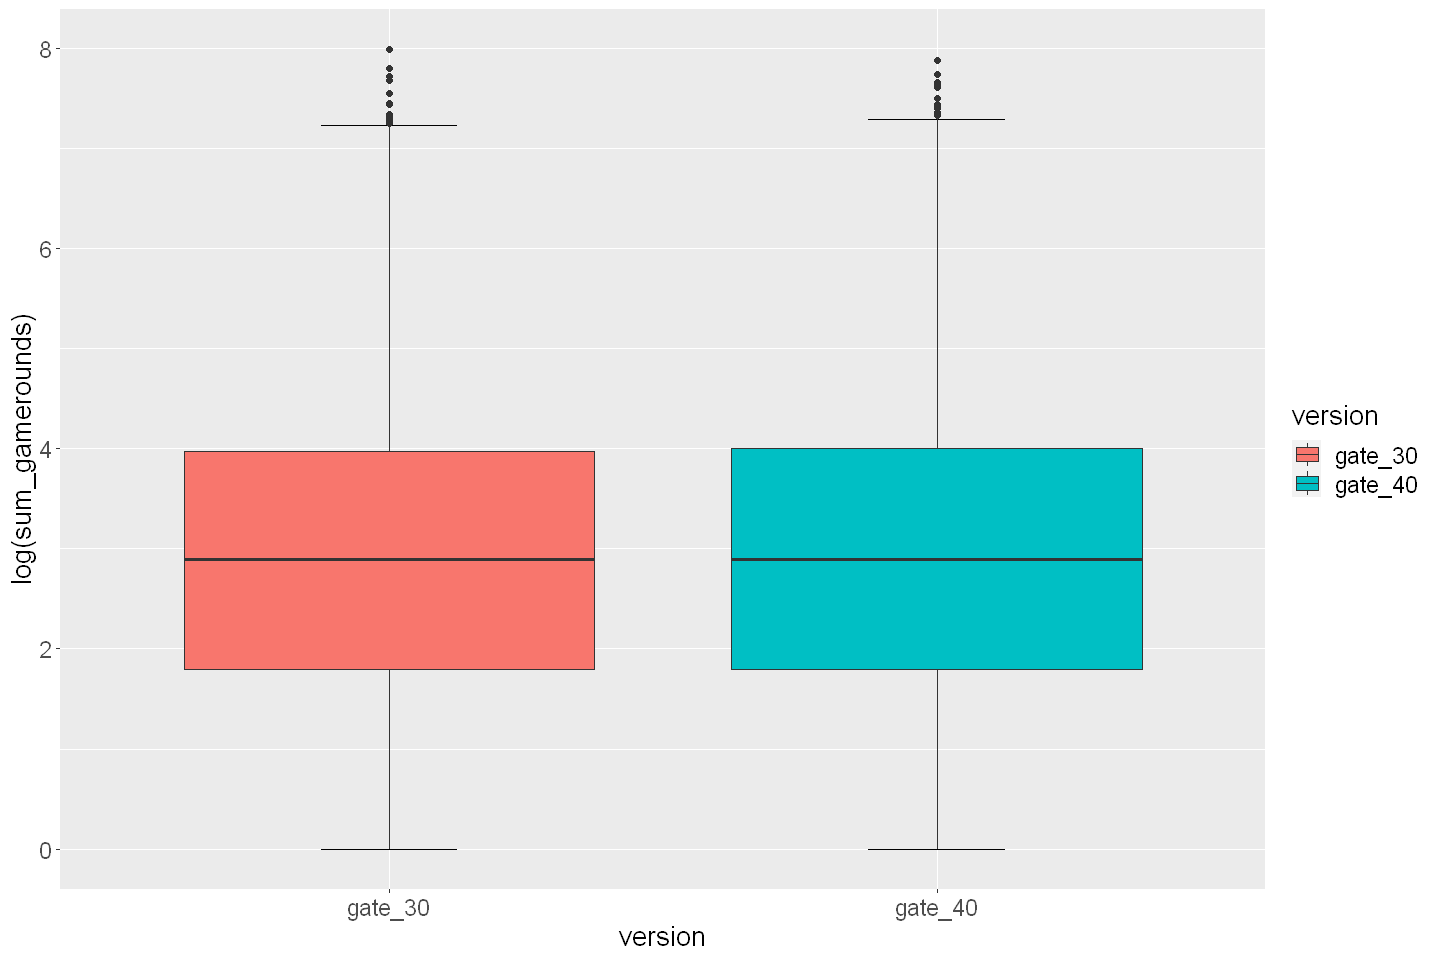

In [51]:
df_filtered %>% ggplot( aes(x = version, y = log(sum_gamerounds), fill = version)) + 
  stat_boxplot(geom = "errorbar",
               width = 0.25) + 
  geom_boxplot() + My_Theme

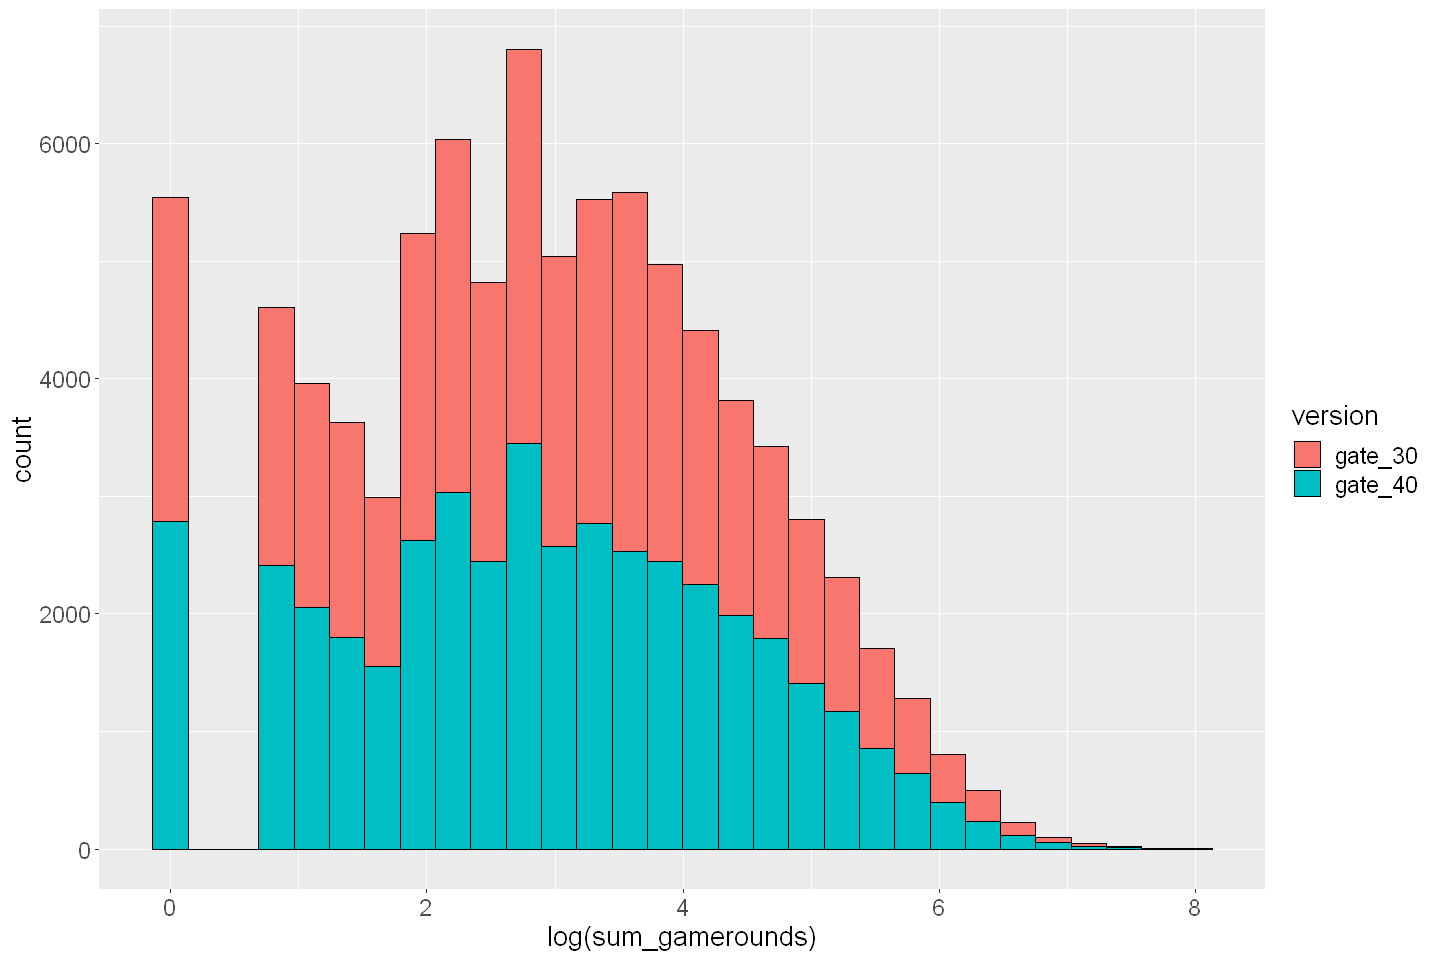

In [19]:
df_filtered %>% ggplot(aes(x=log(sum_gamerounds), fill = version)) + geom_histogram(col='black', bins=30) + My_Theme  

#### If you look at the histogram of the number of times the game was played over a two-week period after installing the game, you'll notice that it's very skewed to the left.

#### NOTE: If the data is not normally distributed, it is desirable to normalize the data through logarithmic transformation and outlier processing, but we will omit this in this exercise.

    This distribution doesn't look like normal one.
    For additional practice let's check it using statistical test (Kolmogorov-Smirnov or Shapiro).

    When to Use Each Test:
    Small Sample Sizes: Use the Shapiro-Wilk test. Preferred for smaller sample sizes (n ≤ 50).
    Large Sample Sizes: Use the Kolmogorov-Smirnov test.
    Comparing Two Samples: Use the two-sample K-S test.

In [20]:
# Perform the one-sample K-S test
ks_test_result <- ks.test(df_filtered$sum_gamerounds, "pnorm", mean = mean(df_filtered$sum_gamerounds), sd = sd(df_filtered$sum_gamerounds))

# Display the test result
print(ks_test_result)

Warning message in ks.test.default(df_filtered$sum_gamerounds, "pnorm", mean = mean(df_filtered$sum_gamerounds), :
"ties should not be present for the Kolmogorov-Smirnov test"



	Asymptotic one-sample Kolmogorov-Smirnov test

data:  df_filtered$sum_gamerounds
D = 0.3069, p-value < 2.2e-16
alternative hypothesis: two-sided



### P-value is too low, distribution isn't normal.

In [21]:
if (!require(gridExtra)) install.packages('gridExtra', dependencies=TRUE) 
suppressWarnings(suppressMessages(library(gridExtra)))

Loading required package: gridExtra


Attaching package: 'gridExtra'


The following object is masked from 'package:dplyr':

    combine




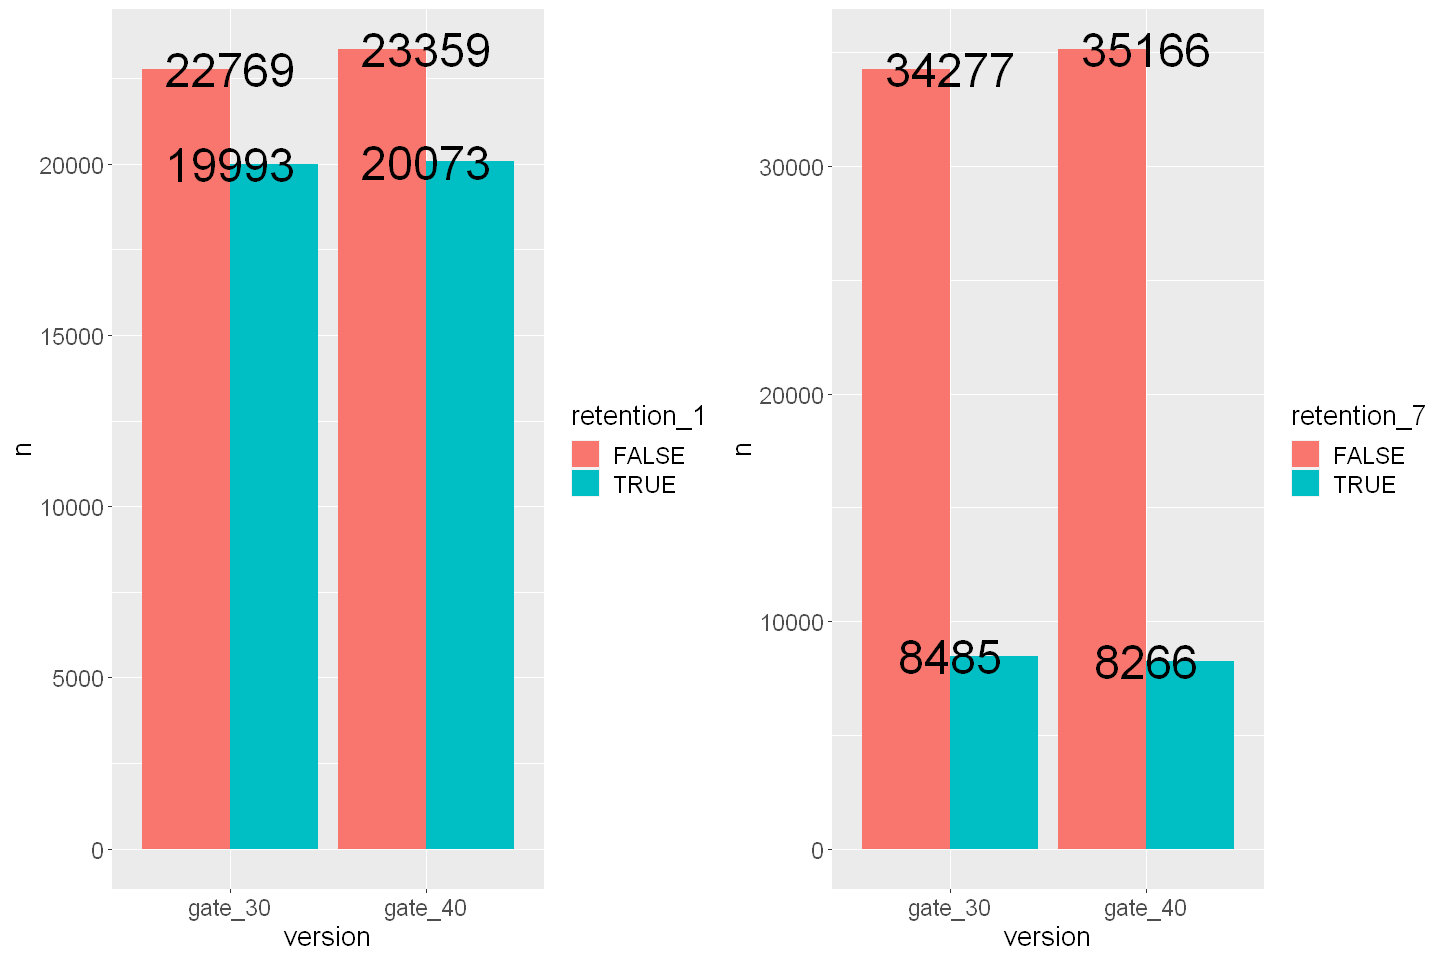

In [22]:
g1 <- df_filtered %>% 
group_by(version, retention_1) %>% 
count() %>% 
ggplot(aes(x=version, y=n, fill=retention_1)) + geom_bar(stat = "identity", position = "dodge") + geom_text(aes(label = n), size = 10) + My_Theme

g2 <- df_filtered %>% 
group_by(version,retention_7) %>% 
count() %>% 
ggplot(aes(x=version, y=n, fill=retention_7)) + geom_bar(stat = "identity", position = "dodge") + geom_text(aes(label = n), size = 10) + My_Theme

grid.arrange(g1, g2, ncol = 2)

    After completing this simple EDA, I think we can apply A/B testing from three perspectives.
    
    Since gate_30 can be interpreted as the old version and gate_40 as the new version with some modifications, we are interested in whether various indicators in gate_40 are improved compared to gate_30.
    
    Players in gate_40 will play more games on average over a two-week period than players in gate_30.
    
    Players corresponding to gate_40 will have a higher rate of re-login a day later than players corresponding to gate_30.
    
    Players who fall into gate_40 will have a higher chance of returning a week later than players who fall into gate_30.

# A/B test hypothesis setting

    1. Regarding sum_gamerounds
    
    - Players corresponding to gate_40 will play more games on average over a two-week period than players corresponding to gate_30 .
    
     
    
    2. Retention_1 related
    
    - Players corresponding to gate_40 will have a higher rate of reconnecting after a day than players corresponding to gate_30 .
    
     
    
    3. Retention_7 related
    
    - Players corresponding to gate_40 will have a higher  rate of re-login after a week than players corresponding to gate_30 .

### Metric Definition 
    Hypothesis 1) Average number of game plays over 2 weeks
    
    Hypothesis 2) Rate of returning to the game after 1 day
    
    Hypothesis 3) Rate of returning to the game after 7 days

### Experimental design
    -Control group: gate_30
    
    -Experimental group: gate_40

## 1. Players corresponding to gate_40 will play more games on average over a two-week period than players corresponding to gate_30.

Loading required package: gplots


Attaching package: 'gplots'


The following object is masked from 'package:stats':

    lowess




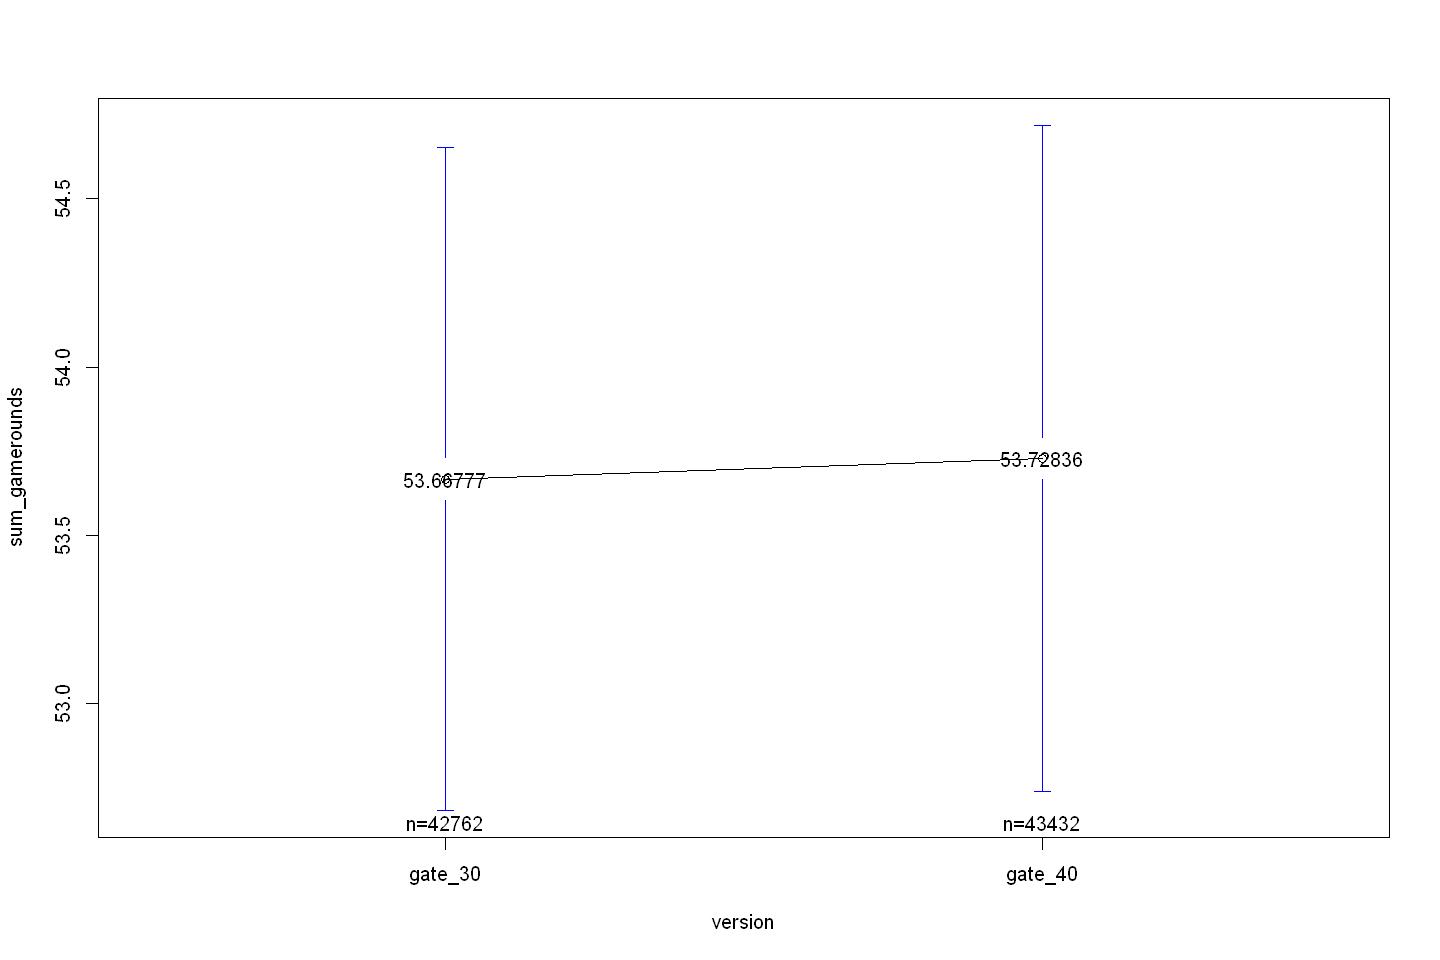

In [23]:
if (!require(gplots)) install.packages('gplots', dependencies=TRUE) 
suppressWarnings(suppressMessages(library(gplots)))

plotmeans(sum_gamerounds ~ version, df_filtered, mean.labels = T)

#### Since the target variable is a continuous variable and sample size of each group is large (>1000). we assume that the normality assumption by CLT is satisfied.) , let's check whether the variance of each group is the same.

#### If variance of each group is the same, we use Student's t-test; othwewise use Welch's Two Sample t-test

![image.png](https://miro.medium.com/v2/resize:fit:4800/format:webp/1*Vzkwzrs4DOmBBa1LymW-PQ.png)

from https://towardsdatascience.com/a-b-testing-a-complete-guide-to-statistical-testing-e3f1db140499

In [24]:
var.test(sum_gamerounds ~ version, df_filtered)


	F test to compare two variances

data:  sum_gamerounds by version
F = 0.97449, num df = 42761, denom df = 43431, p-value = 0.00731
alternative hypothesis: true ratio of variances is not equal to 1
95 percent confidence interval:
 0.9562580 0.9930633
sample estimates:
ratio of variances 
         0.9744862 


#### Since the p-value of the equal variance test result is less than 0.05, it can be interpreted that the variances of the two groups are not equal.

In [25]:
t.test(sum_gamerounds ~ version, df_filtered, var.equal = FALSE, alter = "less")


	Welch Two Sample t-test

data:  sum_gamerounds by version
t = -0.085181, df = 86191, p-value = 0.4661
alternative hypothesis: true difference in means between group gate_30 and group gate_40 is less than 0
95 percent confidence interval:
     -Inf 1.109449
sample estimates:
mean in group gate_30 mean in group gate_40 
             53.66777              53.72836 


#### Since the p-value of the test result is 0.4661, which is much larger than 0.05, the null hypothesis is accepted.

#### In other words, the average number of games played over two weeks by players corresponding to gate_40 cannot be said to be statistically higher than that of gate_30.

#### Perform Mann-Whitney U Test

In [29]:
# Grouping the data by the relevant variable (e.g., 'group')
group1 <- df_filtered %>% filter(version == "gate_30") %>% pull(sum_gamerounds)
group2 <- df_filtered %>% filter(version == "gate_40") %>% pull(sum_gamerounds)

# Perform Mann-Whitney U Test
wilcox.test(group1, group2)


	Wilcoxon rank sum test with continuity correction

data:  group1 and group2
W = 934332123, p-value = 0.1177
alternative hypothesis: true location shift is not equal to 0


#### Since the p-value is greater than 0.05. Same conclusion as above

## 2. Players corresponding to gate_40 will have a higher rate of reconnecting after one day than players corresponding to gate_30.
#### In this hypothesis test, the target variable is a binary categorical variable consisting of False or True.
#### Therefore, we will use the prop.test() function to test the difference in population proportions between the two groups.

In [30]:
#  create a table consisting of the version and retention_1 variables.
table_1 <- addmargins(table(df_filtered$version, df_filtered$retention_1), margin=2)
table_1

,FALSE,TRUE,Sum
gate_30,22769,19993,42762
gate_40,23359,20073,43432


In [39]:
prop.test(x=c(table_1[1,2], table_1[2,2]), n=c(table_1[1,3], table_1[2,3]), alter = "greater")


	2-sample test for equality of proportions with continuity correction

data:  c(table_1[1, 2], table_1[2, 2]) out of c(table_1[1, 3], table_1[2, 3])
X-squared = 2.4767, df = 1, p-value = 0.05777
alternative hypothesis: greater
95 percent confidence interval:
 -0.0002415159  1.0000000000
sample estimates:
   prop 1    prop 2 
0.4675413 0.4621707 


#### Since the p-value of the test result is 0.0577, which is much larger than 0.05, the null hypothesis is accepted.

#### In other words, it cannot be said that the rate at which players corresponding to gate_40 reconnect after one day is statistically higher than that of players corresponding to gate_30.

#### Perform a Chi-Square Test in R to compare retention rates between two groups for rentention_1

#### •	Chi-Square Test: Used to test the independence of two categorical variables

In [41]:
# Perform Chi-Square Test
chisq.test(table_1)


	Pearson's Chi-squared test

data:  table_1
X-squared = 2.4983, df = 2, p-value = 0.2868


#### Since the p-value of the test result is 0.2868, we accept (do not reject) null hypothesis

## 3. Players corresponding to gate_40 will have a higher rate of re-login after a week than players corresponding to gate_30.

#### Likewise, since we are interested in the proportion of TRUE (the number of players who logged back in after a week) in each group

In [42]:
#  create a table consisting of the version and retention_1 variables.
table_2 <- addmargins(table(df_filtered$version, df_filtered$retention_7), margin=2)
table_2

,FALSE,TRUE,Sum
gate_30,34277,8485,42762
gate_40,35166,8266,43432


In [43]:
prop.test(x=c(table_2[1,2], table_2[2,2]), n=c(table_2[1,3], table_2[2,3]), alter = "greater")


	2-sample test for equality of proportions with continuity correction

data:  c(table_2[1, 2], table_2[2, 2]) out of c(table_2[1, 3], table_2[2, 3])
X-squared = 8.9849, df = 1, p-value = 0.001361
alternative hypothesis: greater
95 percent confidence interval:
 0.00364588 1.00000000
sample estimates:
   prop 1    prop 2 
0.1984238 0.1903205 


#### The p-value of the test result is 0.001361, which islower than 0.05, so we reject the null hypothesis.

#### In other words, it can be said that the rate at which players corresponding to gate_40 reconnect after a week is statistically higher than that of players corresponding to gate_30.

In [44]:
# Perform Chi-Square Test
chisq.test(table_2)


	Pearson's Chi-squared test

data:  table_2
X-squared = 9.0366, df = 2, p-value = 0.01091


#### Chi-squared test result p-value < 0.05. We may reject the null hypothesis!

###  Bootstrapping in A/B testing is a statistical technique used to estimate the sampling distribution of a statistic by resampling with replacement from the observed data. This method allows you to calculate standard errors, construct confidence intervals, and perform hypothesis testing without relying on strong parametric assumptions.

In [52]:
# Load necessary library
if (!require(boot)) install.packages('boot', dependencies=TRUE) 
suppressWarnings(suppressMessages(library(boot)))

In [46]:
# Define the statistic function for bootstrapping
ab_stat <- function(data, indices, group_col, metric_col) {
  # Resample the data based on the provided indices
  d <- data[indices, ]
  
  # Calculate the mean metric for each group
  means <- tapply(as.numeric(as.logical(d[[metric_col]])), d[[group_col]], mean, na.rm = TRUE)
  
  # Return the difference in means between the groups
  return(diff(means))
}

In [47]:
# For 1-day retention
set.seed(42)
boot_1 <- boot(data = df_filtered, statistic = ab_stat, R = 1000, group_col = "version", metric_col = "retention_1")

# For 7-day retention
set.seed(42)
boot_7 <- boot(data = df_filtered, statistic = ab_stat, R = 1000, group_col = "version", metric_col = "retention_7")

In [48]:
# Calculate 95% confidence intervals for 1-day retention
ci_95_1 <- boot.ci(boot_1, type = "perc")
ci_95_1
print("--------------------------------------------\n")
# Calculate 95% confidence intervals for 7-day retention
ci_95_7 <- boot.ci(boot_7, type = "perc")
ci_95_7

BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot_1, type = "perc")

Intervals : 
Level     Percentile     
95%   (-0.0127,  0.0008 )  
Calculations and Intervals on Original Scale

[1] "--------------------------------------------\n"


BOOTSTRAP CONFIDENCE INTERVAL CALCULATIONS
Based on 1000 bootstrap replicates

CALL : 
boot.ci(boot.out = boot_7, type = "perc")

Intervals : 
Level     Percentile     
95%   (-0.0132, -0.0029 )  
Calculations and Intervals on Original Scale

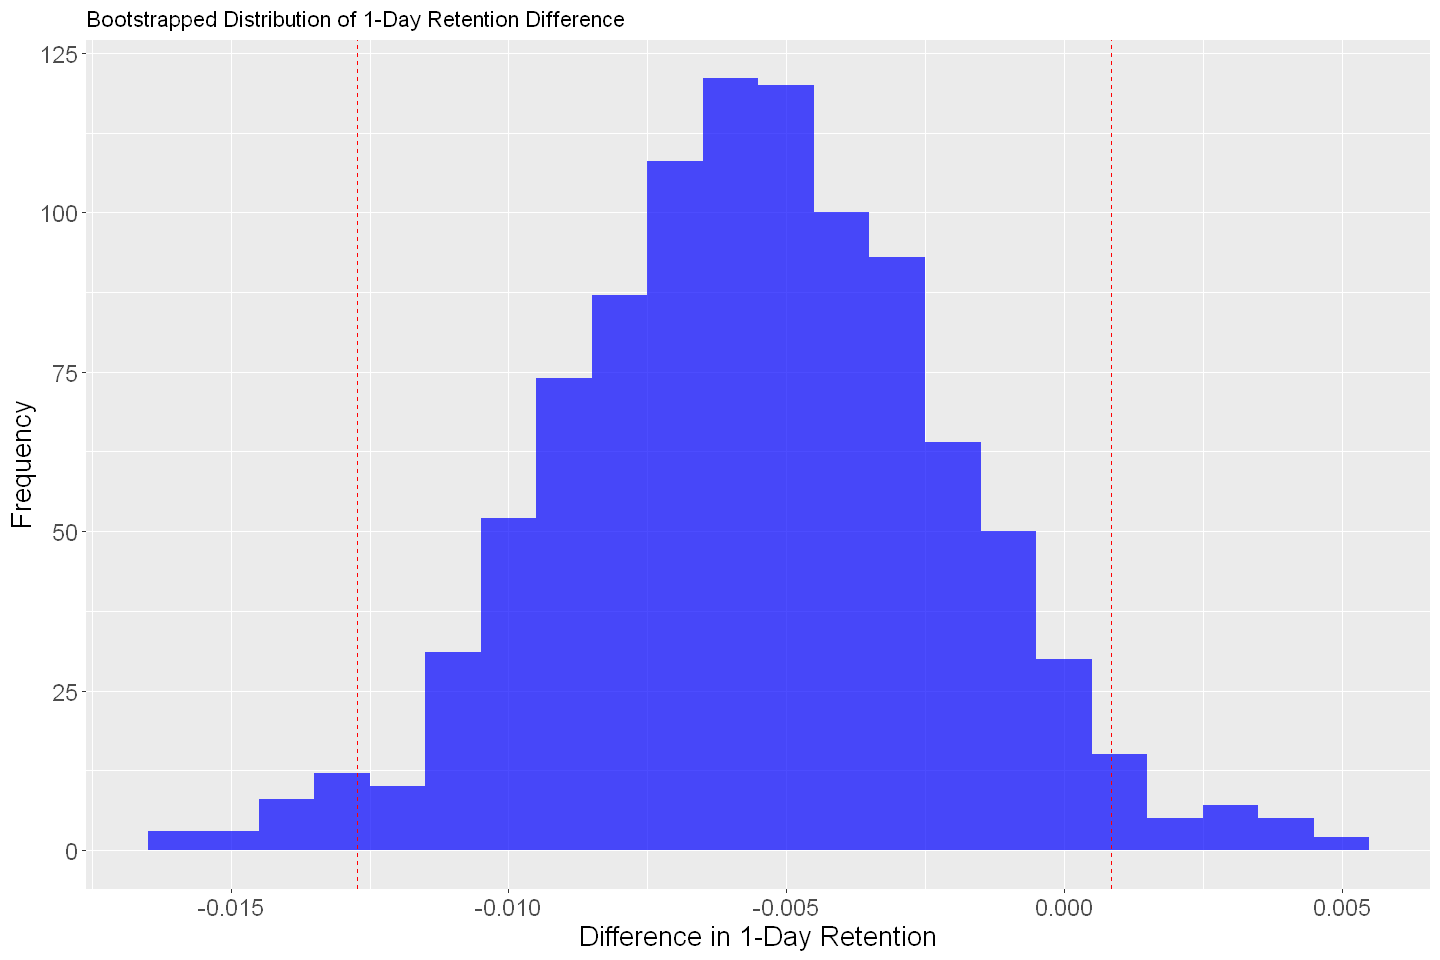

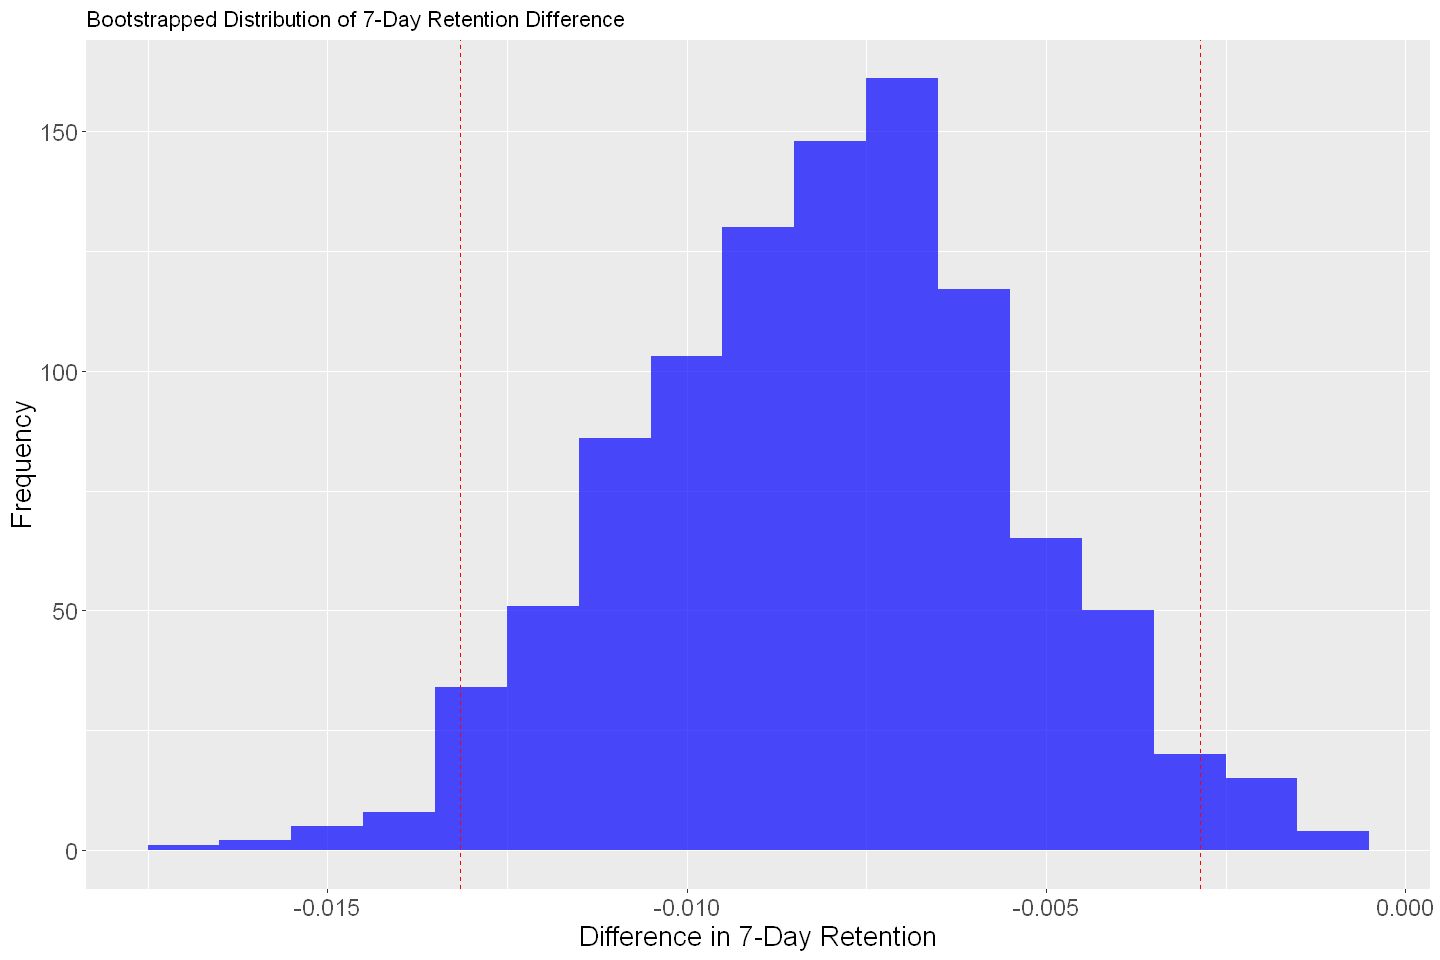

In [49]:
# Plot for 1-day retention
ggplot(data.frame(boot_1$t), aes(x = boot_1$t)) +
  geom_histogram(binwidth = 0.001, fill = "blue", alpha = 0.7) +
  geom_vline(xintercept = ci_95_1$perc[4], color = "red", linetype = "dashed") +  # lower bound
  geom_vline(xintercept = ci_95_1$perc[5], color = "red", linetype = "dashed") +  # upper bound
  ggtitle("Bootstrapped Distribution of 1-Day Retention Difference") +
  xlab("Difference in 1-Day Retention") +
  ylab("Frequency") + My_Theme

# Plot for 7-day retention
ggplot(data.frame(boot_7$t), aes(x = boot_7$t)) +
  geom_histogram(binwidth = 0.001, fill = "blue", alpha = 0.7) +
  geom_vline(xintercept = ci_95_7$perc[4], color = "red", linetype = "dashed") +  # lower bound
  geom_vline(xintercept = ci_95_7$perc[5], color = "red", linetype = "dashed") +  # upper bound
  ggtitle("Bootstrapped Distribution of 7-Day Retention Difference") +
  xlab("Difference in 7-Day Retention") +
  ylab("Frequency") + My_Theme

###    The interval includes 0  in 1-day retention, which means there's a possibility that there is no difference between groups A and B. The data does not provide strong enough evidence to suggest that one version is better than the other in terms of 1-day retention.

### The interval not includes 0  in 7-day retention, which means there's a possibility that there is difference between groups A and B.

# Conclusion

## To summarize the final results of the A/B test, the average number of game plays over two weeks, the rate of reconnection after one day, and the rate of reconnection after one week for the gate_40 version were not statistically higher than those for the gate_30 version.

## This means that the revised version did not have a significant impact on improving various indicators, so it is reasonable to maintain the existing version gate_30 (control group) or plan other revisions instead of the revisions used in version gate_40.

# Reference

    https://velog.io/@giyu11/AB-test-with-Cookie-Cats-dataset
    https://www.kaggle.com/code/nitishsahay/mobile-games-a-b-testing-with-cookie-cats-using-r
    https://www.statmethods.net/stats/frequencies.html
    https://www.flutterbys.com.au/stats/course.html
    https://bookdown.org/eariascastro/principles_of_statistical_analysis/